In this notebook diffrent parameters are tested, inorder to find a optimal choice of parameters for an LSTM network with respect to validation preformence. The traing data and the validation data contains samples form skier 1, 2, 3. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense,Bidirectional
from keras.layers import LSTM, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
path = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/Strike_Data_As_Np')

In [3]:
X_First = np.load(path + '/' + 'X_First_Skier.npy')
Y_First = np.load(path + '/' + 'Y_First_Skier.npy')
feature_list_First = []
with open(path + "/keys_First_Skier.txt", "r") as f:
      for line in f:
        feature_list_First.append(line.strip('\n'))

In [4]:
X_Second = np.load(path + '/' + 'X_Second_Skier.npy')
Y_Second = np.load(path + '/' + 'Y_Second_Skier.npy')
feature_list_Second = []
with open(path + "/keys_Second_Skier.txt", "r") as f:
      for line in f:
        feature_list_Second.append(line.strip('\n'))

In [5]:
X_Third = np.load(path + '/' + 'X_Third_Skier.npy')
Y_Third = np.load(path + '/' + 'Y_Third_Skier.npy')
feature_list_Third = []
with open(path + "/keys_Third_Skier.txt", "r") as f:
      for line in f:
        feature_list_Third.append(line.strip('\n'))

In [6]:
feature_Dict = {i:feature_list_Second[i] for i in range(len(feature_list_Second)-1)}
print(len(feature_Dict))

17


In [7]:
print(X_First.shape)
print(X_Second.shape)
print(X_Third.shape)
print(Y_First.shape)
print(Y_Second.shape)
print(Y_Third.shape)

(452, 140, 22)
(382, 140, 18)
(844, 140, 22)
(452, 4)
(382, 4)
(844, 4)


In [8]:
def split_to_test_train_data(X_List,Y_List,ratio,time_step,dimX,nbr_of_classes):
    
    nbr_of_data = len(X_List)
    min_samples = min([x.shape[0] for x in X_List])
    h = int((1-ratio)*min_samples)
    nbr_of_test = [x.shape[0]-h for x in X_List]
    X = np.zeros((h*nbr_of_data,time_step,dimX))
    Y = np.zeros((h*nbr_of_data,nbr_of_classes))
    X_Test_List = [np.zeros((sum(nbr_of_test),time_step,dimX))]
    Y_Test_List = [np.zeros((sum(nbr_of_test),nbr_of_classes))]
    
    for i in range(nbr_of_data):
        x_d = np.zeros((nbr_of_test[i],time_step,dimX))
        y_d = np.zeros((nbr_of_test[i],nbr_of_classes))
        X_Test_List.append(x_d)
        Y_Test_List.append(y_d)

    test_samp_prev = 0 
    for i in range(nbr_of_data):
        x = X_List[i][:,:,:dimX]
        y = Y_List[i]
        test_samp = nbr_of_test[i] + test_samp_prev
        X[h*i:h*(i+1),:,:] = x[:h,:,:]
        Y[h*i:h*(i+1),:] = y[:h,:]
        X_Test_List[0][test_samp_prev:test_samp,:,:] = x[h:,:,:]
        Y_Test_List[0][test_samp_prev:test_samp,:] = y[h:,:]
        X_Test_List[i+1] = x[h:,:,:]
        Y_Test_List[i+1] = y[h:,:]
        test_samp_prev = test_samp
        
    return X,Y,X_Test_List,Y_Test_List

In [9]:
dim_X = len(feature_Dict)
X_List = [X_First,X_Second,X_Third]
Y_List = [Y_First,Y_Second,Y_Third]
ratio = 0.2
time_step = 140
nbr_of_classes = 4
X,Y,X_Test_List,Y_Test_List = split_to_test_train_data(X_List,Y_List,ratio,time_step,dim_X,nbr_of_classes)
nbr_test = X_Test_List[0].shape[0]
X_Test = X_Test_List[0][:int((3*nbr_test)/4),:,:]
Y_Test = Y_Test_List[0][:int((3*nbr_test)/4),:]
X_Val = X_Test_List[0][int((3*nbr_test)/4):,:,:]
Y_Val = Y_Test_List[0][int((3*nbr_test)/4):,:]

In [10]:
print(X.shape)
print(Y.shape)
print(X_Test.shape)
print(Y_Test.shape)

(915, 140, 17)
(915, 4)
(572, 140, 17)
(572, 4)


In [11]:
def get_strike(strike,strike_l,pad):
    
    for j in range(strike_l-3):
        if strike[j,1] == strike[j+1,1] == strike[j+2,1] == pad:
            plot_strike = strike[0:j-1,1]
            time_strike = strike[0:j-1,0]
            break
        elif strike[strike_l-2,0] > 0:
            plot_strike = strike[:,1]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [12]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [13]:
def plot_skiedata(true_Y,X,figure):

    nbr_of_classes = 4
    colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    nbr_of_test = X.shape[0]
    strike_l = X.shape[1]
    pad = 0

    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)

        plt.figure(figure,figsize=(15, 4))
        plt.title('True gear')
        plt.scatter(time_true,strike_true,label = 'True class: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend()
        #plt.axis([280, 320, 0, 400])
    figure = figure + 1
    return figure

In [14]:
delta_t = 0.02
X = change_time_axis_for_plot(X,delta_t)
X_Test = change_time_axis_for_plot(X_Test,delta_t)
X_Val = change_time_axis_for_plot(X_Val,delta_t)

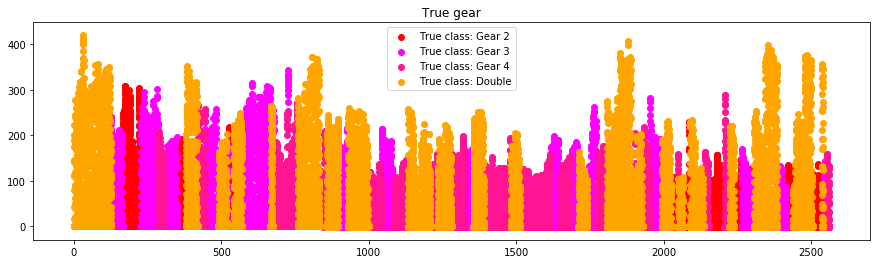

In [45]:
true_Y = np.argmax(Y,axis = 1)
figure = plot_skiedata(true_Y,X,0)

In [16]:
def LSTM_Two_Dense_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    print(sequence_input.shape)
    x = LSTM(26,return_sequences=True)(sequence_input)
    print(x.shape)
    x = Dense(X.shape[1], activation='relu')(x)
    print(x.shape)
    x = Flatten()(x)
    print(x.shape)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_64():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(64,return_sequences=True)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_126():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(126,return_sequences=True)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_256():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(256,return_sequences=True)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_64_Drop():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(64,return_sequences=True, recurrent_dropout = 0.2)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def LSTM_Two_Dense_126_Drop():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = LSTM(126,return_sequences=True, recurrent_dropout = 0.2)(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Training model: LSTM_Two_Dense_26
(?, 140, 16)
(?, ?, 26)
(?, 140, 140)
(?, ?)
Train on 915 samples, validate on 191 samples
Epoch 1/20
915/915 [==============================] - 185s 202ms/step - loss: 0.6121 - acc: 0.7716 - val_loss: 0.5220 - val_acc: 0.7592
Epoch 2/20
915/915 [==============================] - 181s 198ms/step - loss: 0.3206 - acc: 0.8984 - val_loss: 0.3800 - val_acc: 0.8377
Epoch 3/20
915/915 [==============================] - 181s 197ms/step - loss: 0.2034 - acc: 0.9388 - val_loss: 0.4429 - val_acc: 0.8168
Epoch 4/20
915/915 [==============================] - 180s 196ms/step - loss: 0.1435 - acc: 0.9574 - val_loss: 0.3367 - val_acc: 0.8743
Epoch 5/20
915/915 [==============================] - 178s 195ms/step - loss: 0.1049 - acc: 0.9716 - val_loss: 0.4240 - val_acc: 0.8377
Epoch 6/20
915/915 [==============================] - 181s 198ms/step - loss: 0.0687 - acc: 0.9803 - val_loss: 0.3227 - val_acc: 0.8848
Epoch 7/20
915/915 [==============================] - 179s 

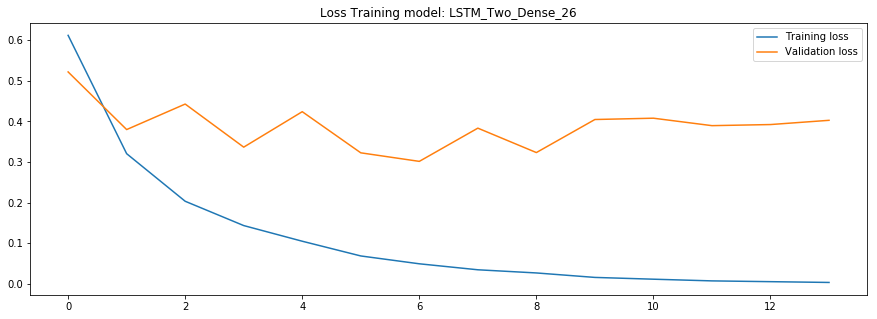

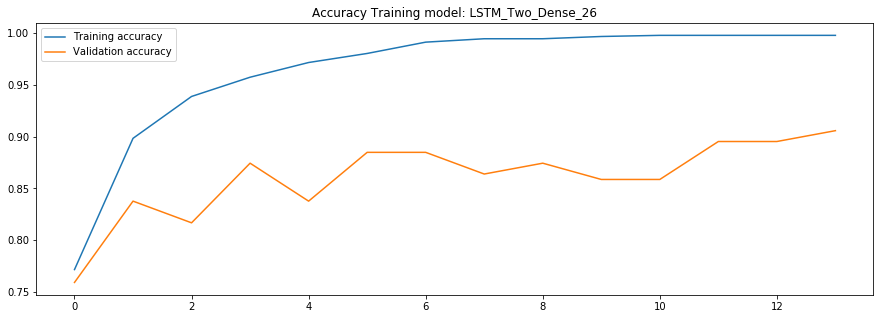

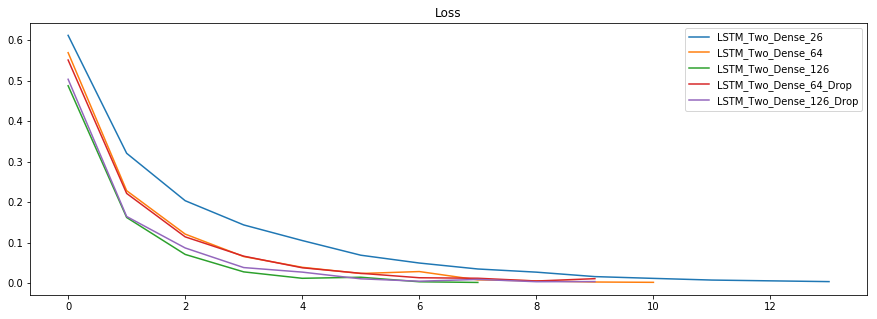

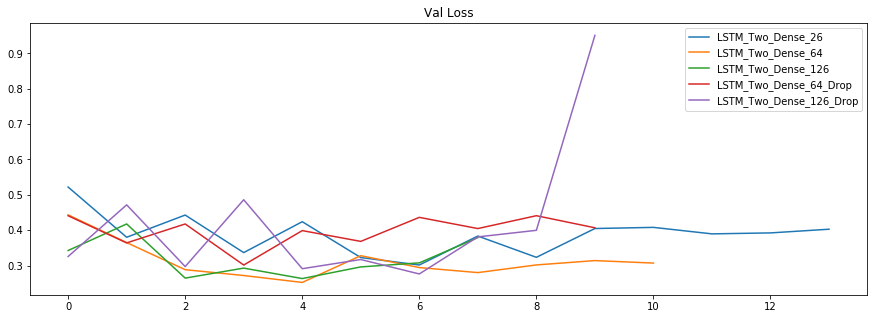

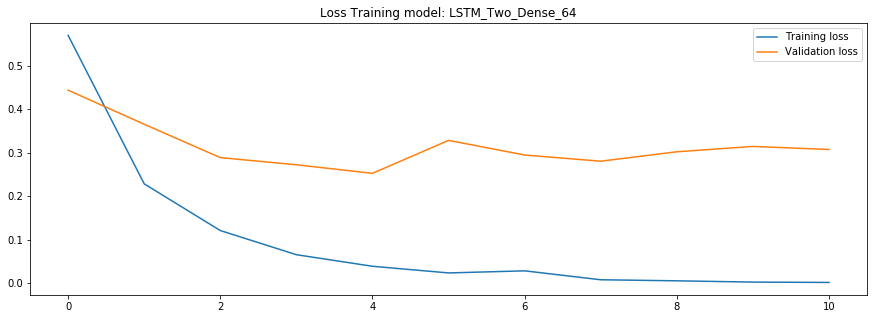

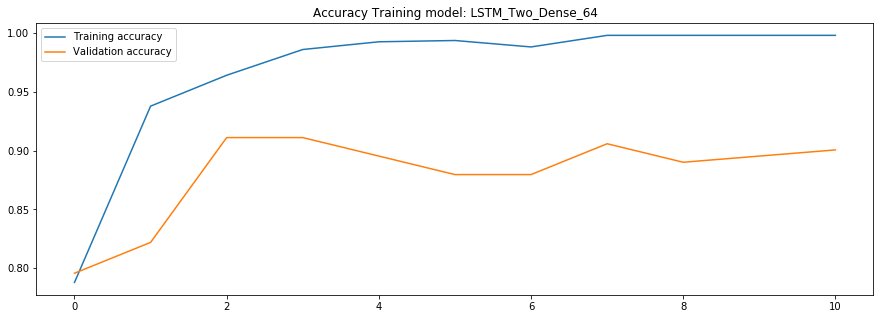

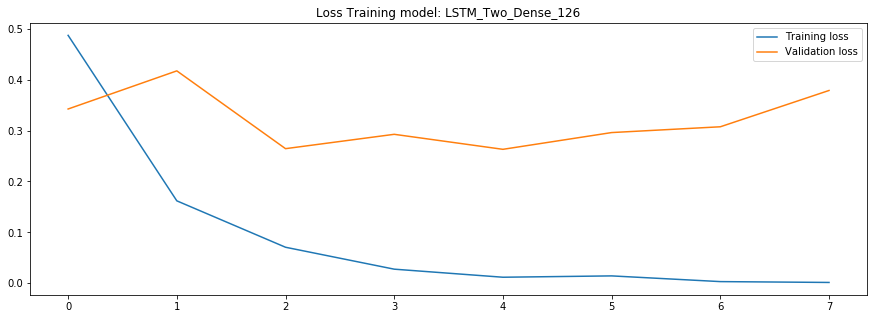

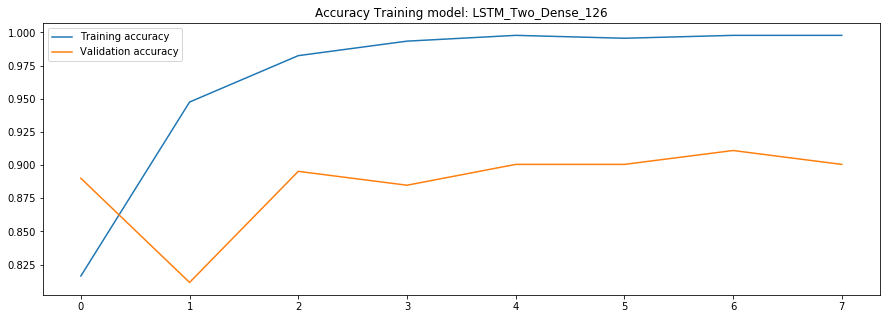

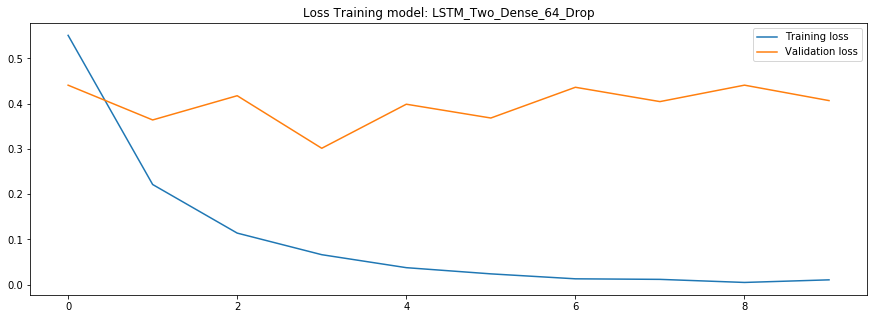

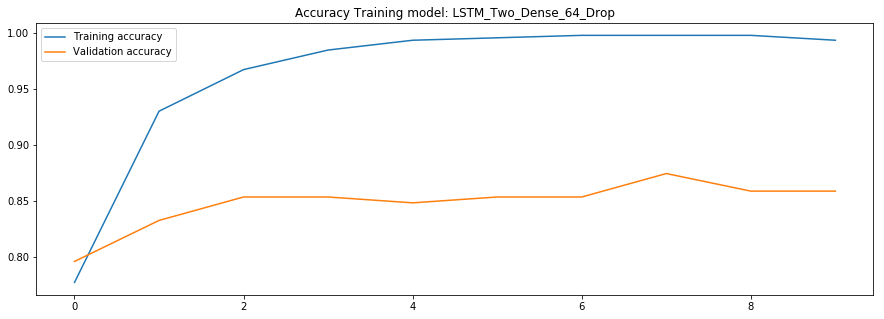

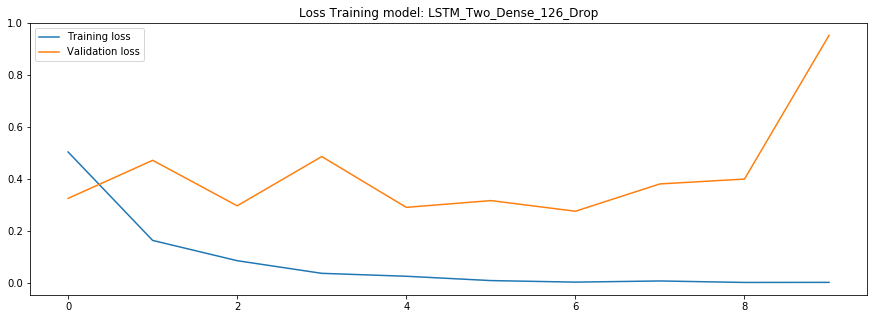

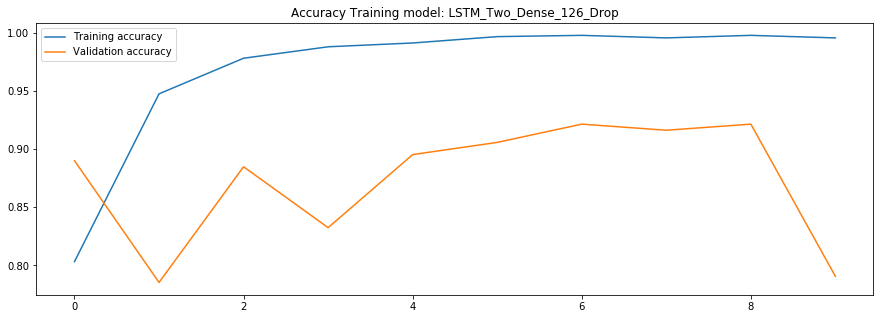

In [18]:
model_names = ['LSTM_Two_Dense_26','LSTM_Two_Dense_64','LSTM_Two_Dense_126','LSTM_Two_Dense_64_Drop','LSTM_Two_Dense_126_Drop']
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=3)
i = 0
for name in model_names:
    print('Training model:',name)
    model = globals()[name]()
    #tb = TensorBoard(log_dir='./logs/'+name)
    history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [eS])
    print('Done!')
    plt.figure(2*i,[15,5])
    plt.title('Loss Training model: ' + name)
    plt.plot(history.history['loss'],label = 'Training loss')
    plt.plot(history.history['val_loss'],label = 'Validation loss')
    plt.legend()
    plt.figure(2*i + 1,[15,5])
    plt.plot(history.history['acc'],label = 'Training accuracy')
    plt.plot(history.history['val_acc'],label = 'Validation accuracy')
    plt.title('Accuracy Training model: ' + name)
    plt.legend()
    plt.figure(2*len(model_names),[15,5])
    plt.title('Loss')
    plt.plot(history.history['loss'],label = name)
    plt.legend()
    plt.figure(2*len(model_names) + 1,[15,5])
    plt.title('Val Loss')
    plt.plot(history.history['val_loss'],label = name)
    plt.legend()

    i = i + 1

In [19]:
model = LSTM_Two_Dense_126()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=5)
mCp = ModelCheckpoint('LSTM_1_2_3_New.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X[:,:,1:], Y, epochs=20, batch_size=1, validation_data=(X_Val[:,:,1:],Y_Val),shuffle = True,callbacks = [eS,mCp])

Train on 915 samples, validate on 191 samples
Epoch 1/20
915/915 [==============================] - 187s 205ms/step - loss: 0.4875 - acc: 0.8230 - val_loss: 0.4360 - val_acc: 0.8010
Epoch 2/20
915/915 [==============================] - 188s 206ms/step - loss: 0.1670 - acc: 0.9454 - val_loss: 0.2465 - val_acc: 0.9267
Epoch 3/20
915/915 [==============================] - 192s 210ms/step - loss: 0.0794 - acc: 0.9770 - val_loss: 0.2643 - val_acc: 0.8953
Epoch 4/20
915/915 [==============================] - 188s 206ms/step - loss: 0.0347 - acc: 0.9923 - val_loss: 0.2844 - val_acc: 0.8901
Epoch 5/20
915/915 [==============================] - 190s 208ms/step - loss: 0.0168 - acc: 0.9967 - val_loss: 0.2158 - val_acc: 0.9058
Epoch 6/20
915/915 [==============================] - 188s 205ms/step - loss: 0.0077 - acc: 0.9978 - val_loss: 0.2876 - val_acc: 0.8901
Epoch 7/20
915/915 [==============================] - 191s 209ms/step - loss: 0.0048 - acc: 0.9978 - val_loss: 0.2784 - val_acc: 0.9005
Ep

In [20]:
from keras.models import load_model
model = load_model('LSTM_1_2_3_New.h5')
predY = model.predict(X_Test[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_Test,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

(572, 4)
Accuracy: 0.93
